# Qualitative Analysis 3

In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from lr.text_processing.util import pre_process_nli_df
from collections import Counter
from lr.stats.h_testing import get_paired_t_statistic

## When $\rho=0$ which test examples are affected by the transformation?

In [2]:
m_name = "roberta_large"
data = "mnli"
batch = 1
path = "raw_results/{}/{}/syn_p_h/batch{}/rho_0p00_results.csv".format(data, m_name, batch)
df = pd.read_csv(path)

snli_trans = pd.read_csv("data/{}/test_p_h_syn_noun.csv".format(data))
sin_noun = pd.read_csv("data/{}/syn_noun.csv".format(data))
key2id = {k:i for k,i in zip(sin_noun.key,sin_noun.index)}
f = lambda k: key2id[k]

In [3]:
def filter_df_by_label(df, drop_label='-'):
    """
    drop observations with label 'drop_label'
    """
    return df.loc[df.label != drop_label]

In [4]:
snli_ori = pd.read_csv("data/{}/test.csv".format(data))
snli_ori = filter_df_by_label(snli_ori)
pre_process_nli_df(snli_ori)
snli_ori = snli_ori.reset_index(drop=True)

In [5]:
t = get_paired_t_statistic(df)
t

(17.214962632401, 0.03338932152491474, 19647, 0.27186270418576697)

n = 201 | e_n = 9.6%
0.7910447761194029 [ 0.6952516811175466 , 0.8868378711212592 ]


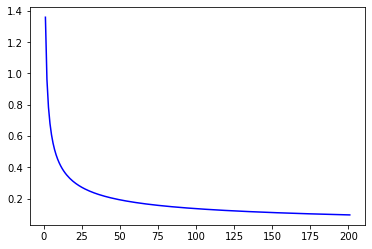

In [37]:
def e(alpha, n):
    return np.sqrt(np.log(2/alpha) / (2*n))

ids = df.loc[(df.A==1) & (df.B==0)]
ids = ids.index.tolist()

b = [20,29,47,63,65, 124, 293, 322, 500,
     537, 6113, 689, 700, 721, 750, 766,
     1064, 1137,1168, 1225, 1283, 1284,
     1338, 1667, 1679, 1827, 2026, 2291,
     2317, 2350, 2374, 2484, 2673, 2723,
     2748, 2834, 2849, 2865, 2956, 3129,
     3144, 3285]

select = b[-1]

b_to_print = [65,1338] 
g = [i for i in ids[:ids.index(select)] if i not in b]
g_to_print = [75, 52, 129, 274, 236, 768]


more = ids[ids.index(select):]

gn = len(g)
bn = len(b)
pct = gn/(gn+bn)

n = gn+bn 
# n = 200


e95 = lambda n: e(0.05, n)
x = np.array(range(1,n+1))

plt.plot(x, e95(x),color="blue");
p = np.random.uniform(0.5,1)
eps = e95(x)
n = eps.argmin()
e_id = eps[n]


print("n = {} | e_n = {:.1%}".format(x[n], e_id))


print(pct,"[",pct-e_id,",", pct+e_id, "]")

In [41]:
ids = df.loc[(df.A==1) & (df.B==0)]
ids = ids.index.tolist()
n = len(ids)
pct = n/df.shape[0]
display(Markdown(r"### When $\rho=0.0$, the number of disrupted sentences (1 to 0) is {} ({:.1%} of the test data)".format(n,pct)))
comb = pd.concat([snli_ori, snli_trans.add_suffix("_2")],1)
# comb = comb.loc[ids]
comb = comb.loc[more]

# display(HTML(comb.head(n).to_html()))
display(HTML(comb.head(1).to_html()))

### When $\rho=0.0$, the number of disrupted sentences (1 to 0) is 1065 (5.4% of the test data)

,premise,hypothesis,label,premise_2,hypothesis_2,label_2
3285,perhaps tax reform doesnt appeal to the new spiritualized side of bradley,bradley is spiritual now,entailment,perhaps taxation reform doesnt prayer to the new spiritualized side of bradley,bradley is negro spiritual now,entailment


## What are the most commom transformations that appear on the error pairs?

In [45]:
spaces = re.compile(' +')
results = []

comb = pd.concat([snli_ori, snli_trans.add_suffix("_2")],1)
ids = comb.index.tolist()
for id_ in ids:
    s = comb.loc[id_].premise + " " + comb.loc[id_].hypothesis
    st = comb.loc[id_].premise_2 + " " + comb.loc[id_].hypothesis_2
    s = spaces.sub(" ",s)
    st = spaces.sub(" ",st)
    s = s.strip()
    st = st.strip()
    s = set(s.split(" "))
    st = set(st.split(" "))
    diff = list(s - st)
    try:
        diff = list(map(f, diff))
        results += diff
    except KeyError:
        pass
#         print(id_)
#         print(s)
#         print(st)
    
    
    
results_c = Counter(results)
dict_id = [i[0] for i in results_c.most_common(10)]
sin_noun.loc[:, "freq"] = [results_c[i]/len(results) for i in sin_noun.index]
sin_noun = sin_noun.sort_values("freq", ascending=False)
sin_noun.loc[:, "freq"] = sin_noun.freq.map(lambda x: "{:.1%}".format(x))
sin_noun.head(10)

,key,value,freq
944,been,be,1.7%
340,also,too,1.0%
8941,said,state,0.9%
4970,help,aid,0.8%
1770,children,child,0.7%
6200,made,do,0.7%
11426,year,yr,0.7%
6862,need,demand,0.7%
948,before,earlier,0.6%
5435,information,info,0.6%
